In [12]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import OneHotEncoder 

from sklearn.model_selection import train_test_split
import scipy.stats as st
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import ShuffleSplit, KFold, GroupKFold, StratifiedKFold
from sklearn import svm
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn import naive_bayes
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_predict, cross_validate
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_absolute_error as mae
from sklearn.preprocessing import LabelEncoder

from keras.utils.np_utils import to_categorical
from keras import models
from keras import layers


import torch
from torch import nn
import torch.nn.functional as F

pd.options.mode.chained_assignment = None  # default='warn'
import warnings
warnings.filterwarnings('ignore')

In [18]:
def seed_everything(seed: int):
    import random, os
    import numpy as np
    import torch
    
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    
seed_everything(33)

In [19]:
class Stacking:
    def __init__(self, data, target):
        self.df = data.copy()
        self.df_ans_train = pd.DataFrame()
        self.df_ans_test = pd.DataFrame()
        self.df_best_cls = {}
        self.scores = {}
        self.n_folds = 5
        self.scores_propor = 0
        self.predictions = 0
        self.pred_val = np.array([])
        
        sklearn_nb = naive_bayes.GaussianNB()
        sklearn_knn = KNeighborsClassifier(50)
        sklearn_lс = LogisticRegression()
        sklearn_tree = DecisionTreeClassifier()
        sklearn_svc = SVC(kernel='poly', C=1, max_iter=100, probability=True)

        self.clf_all = [sklearn_nb, sklearn_knn, sklearn_lс, sklearn_tree, sklearn_svc]
        
        target = 'G3'
        
        cols = self.df.columns
        labelencoder = LabelEncoder()

        num_cols = self.df._get_numeric_data().columns
        for i in list(set(cols) - set(num_cols)):
            if i != 'sex' and i != 'age' and i != 'address':
                self.df[i] = labelencoder.fit_transform(self.df[i].values)
        
        self.y = self.df[target]

        self.X = self.df.drop(target, axis = 1)
        self.x_train, self.x_test, self.y_train, self.y_test = train_test_split(self.X, self.y, test_size=0.2, shuffle=True, random_state=21)
        
        self.x_train = self.x_train.reset_index()
        self.x_train = self.x_train.drop(['index'], axis=1)
        self.y_train = self.y_train.reset_index()
        self.y_train = self.y_train.drop(['index'], axis=1)
        
        self.x_test = self.x_test.reset_index()
        self.x_test = self.x_test.drop(['index'], axis=1)
        self.y_test = self.y_test.reset_index()
        self.y_test = self.y_test.drop(['index'], axis=1)
        
        self.x_test = self.repair(self.x_test)
        
    def repair(self, x):  
        df_wrong, df_right = self.divide_df(df = x)
        #print(df_wrong.shape, df_right.shape)
        self.repair_df(KNeighborsClassifier(), df_wrong, df_right, ['sex', 'age', 'address'])
        x = pd.concat([df_wrong, df_right]).sort_index()
        return x
        
    def divide_df(self, df):
        dct = {'M': 1, 'F': 0, 'D': 2, 'C': 3, 'B': 4, 'A': 5}
        df['sex'] = df['sex'].map(dct)

        df_wrong = df[(df['age'] > 22) | (df['age'] < 15) | ((df['sex'] != 1) & (df['sex'] != 0)) | (df.isnull().any(1))]
        df_wrong['address'] = df_wrong['address'].astype('category').cat.codes

        df_right = df[~((df['age']>22) | (df['age'] < 15) | ((df['sex'] != 1) & (df['sex'] != 0)) | (df.isnull().any(1)))]
        df_right['address'] = df_right['address'].astype('category').cat.codes
        return df_wrong, df_right

    def divide_df_wrong(self, df_wrong, feat):
        if feat == 'sex':
            df_wrong_c = df_wrong[(df_wrong['sex'] != 0) & (df_wrong['sex'] != 1)]
        elif feat == 'age':
            df_wrong_c = df_wrong[(df_wrong['age'] > 22) | (df_wrong['age'] < 15) | (df_wrong['age'].isna())]
        elif feat == 'address':
            df_wrong_c = df_wrong[(df_wrong['address'] != 0) & (df_wrong['address'] != 1)]
        return df_wrong_c

    def repair_df(self, algorythm, df_wrong, df_right, feats):
        for feat in feats:
            X = df_right.drop([feat],axis = 1)
            y = df_right[feat]
            algorythm.fit(X, y)
            X_pred = self.divide_df_wrong(df_wrong, feat)
            if X_pred.shape[0] != 0:
                X_pred[feat] = algorythm.predict(X_pred[X.columns])
                df_wrong[feat].update(X_pred[feat])

    def stacking_alg(self):
        for clf in self.clf_all:
            clf_name = str(clf)[:-2]
            meta_feat, best_cls = self.cross_val_predict_st(clf)

            self.df_ans_train[clf_name] = meta_feat

            
            best_cls.fit(self.repair(self.x_train.copy()), self.y_train)
            self.df_best_cls[clf_name] = best_cls

            self.df_ans_test[clf_name] = self.df_best_cls[clf_name].predict(self.x_test)
            self.scores[clf_name] = accuracy_score(self.df_ans_test[clf_name], self.y_test)
            print(f'{str(clf)} score = {self.scores[clf_name]}','\n')
            
        one_hot_train_y = to_categorical(self.y_train, num_classes = 20)
        one_hot_test_y = to_categorical(self.y_test, num_classes = 20)
        
        model = models.Sequential()
        model.add(layers.Dense(40, activation='relu', input_shape = (self.df_ans_train.shape[1],)))
        model.add(layers.Dense(30, activation='elu'))
        model.add(layers.Dense(25, activation='selu'))
        model.add(layers.Dense(20, activation='softmax')) # кол-во нейронов в выходном слое = кол-ву классов
        model.summary()
        
        model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
        
        #print(len(self.y.unique()), one_hot_train_y.shape)
        history = model.fit(self.df_ans_train.values,
                    one_hot_train_y,
                    epochs=50,
                    batch_size=700)
        
        self.predictions = model.predict(self.df_ans_test)
        for i in self.predictions:
            self.pred_val = np.append(self.pred_val, int(i.argmax()))
        print(accuracy_score(self.pred_val, self.y_test))
        
        
    def cross_val_predict_st(self, clf):
        kf = KFold(n_splits = self.n_folds)
        meta_feat = np.array([], dtype = 'int64')
        
        best_score = 1000000
        best_cls = clf
        
        for train_index, feach_index in kf.split(self.x_train):
            x_train, x_feach = self.x_train.loc[train_index], self.x_train.loc[feach_index]
            y_train, y_feach = self.y_train.loc[train_index], self.y_train.loc[feach_index]
            
            x_train = self.repair(x_train)
            x_feach = self.repair(x_feach)
            
            clf.fit(x_train,y_train)
            predict = clf.predict(x_feach)
            
            if accuracy_score(predict, y_feach) < best_score:
                best_cls = clf
            
            meta_feat = np.concatenate((meta_feat, predict))
        return meta_feat, best_cls
    
    def scor_prop(self):
        w_sum = sum(self.scores.values())
        self.scores_propor = {cls: w / w_sum  for cls, w in self.scores.items()}
        
    def bar_plot_sc_prop(self):
        self.scor_prop()
        sns.barplot(y=list(self.scores_propor.keys()), x = list(self.scores_propor.values()), palette="rocket")
        plt.xticks(rotation=0)
        plt.title('proportion of algorithms', fontsize=16);
        
    def correlation_of_clf(self):
        f = plt.figure(figsize=(10, 9))
        plt.matshow(self.df_ans_train.corr(), fignum=f.number)
        plt.xticks(range(self.df_ans_train.select_dtypes(['number']).shape[1]), self.df_ans_train.select_dtypes(['number']).columns, fontsize=14, rotation=90)
        plt.yticks(range(self.df_ans_train.select_dtypes(['number']).shape[1]), self.df_ans_train.select_dtypes(['number']).columns, fontsize=14)
        cb = plt.colorbar()
        cb.ax.tick_params(labelsize=14)
        plt.title('Correlation Matrix', fontsize=16);

        

In [20]:
data = pd.read_csv('train_features_with_answers.csv')

In [36]:
seed_everything(30)
data_stack = Stacking(data, target = 'G3')

In [37]:
data_stack.stacking_alg() 

GaussianNB() score = 0.04395604395604396 

KNeighborsClassifier(n_neighbors=50) score = 0.12087912087912088 

LogisticRegression() score = 0.12087912087912088 

DecisionTreeClassifier() score = 0.054945054945054944 

SVC(C=1, kernel='poly', max_iter=100, probability=True) score = 0.17582417582417584 

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_52 (Dense)            (None, 40)                240       
                                                                 
 dense_53 (Dense)            (None, 30)                1230      
                                                                 
 dense_54 (Dense)            (None, 25)                775       
                                                                 
 dense_55 (Dense)            (None, 20)                520       
                                                                 
Total params: 

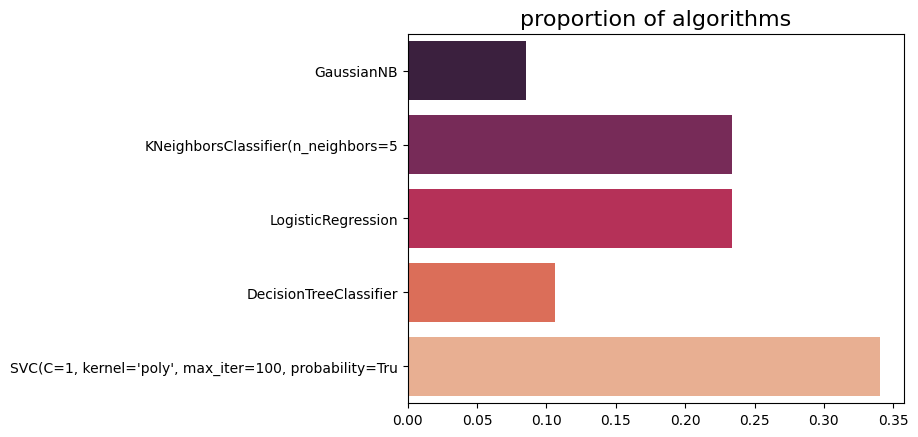

In [38]:
data_stack.bar_plot_sc_prop() 

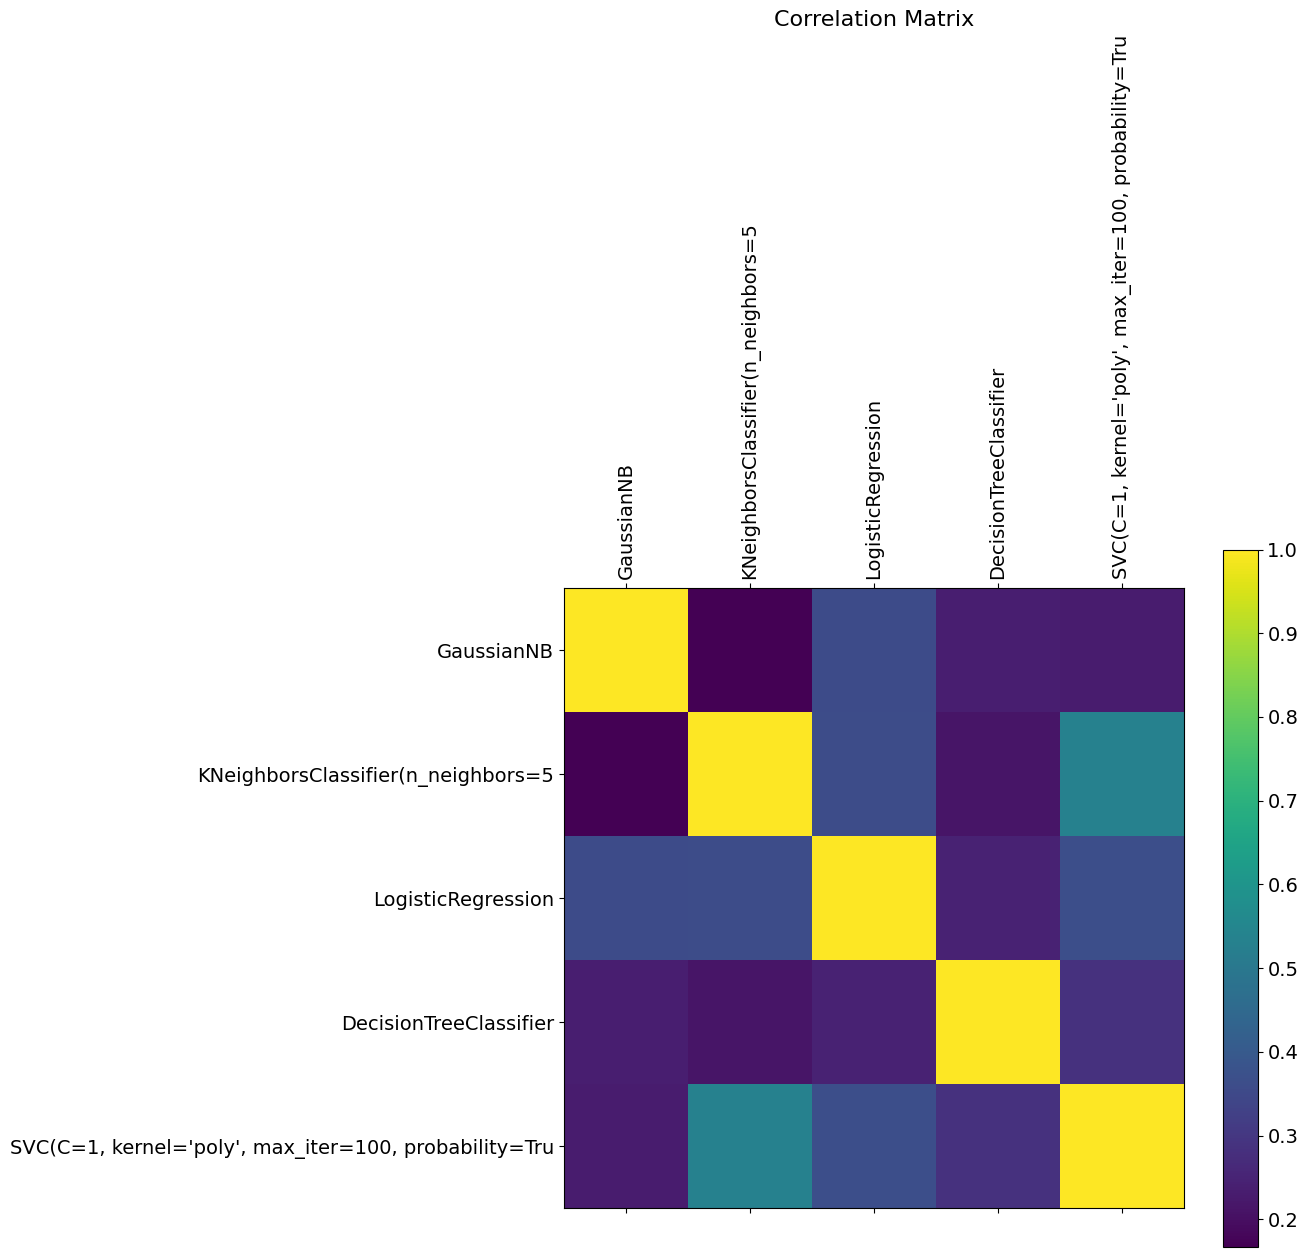

In [39]:
data_stack.correlation_of_clf() 

In [123]:
answ = np.array([])
for i in data_stack.predictions:
    answ = np.append(answ, int(i.argmax()))

In [132]:
sum(answ == data_stack.y_test['G3'].values)


9

In [157]:
data_stack.df_ans_test

,GaussianNB,KNeighborsClassifier(n_neighbors=5,LogisticRegression,DecisionTreeClassifier,"SVC(C=1, kernel='poly', max_iter=100, probability=Tru"
0,18,13,14,14,13
1,0,15,9,9,15
2,16,13,15,17,13
3,11,13,0,0,13
4,7,12,12,11,11
...,...,...,...,...,...
86,9,10,11,10,11
87,9,10,11,13,13
88,14,11,11,8,11
89,16,13,12,12,11
